# **Model Comparision**

Una vez realizada la limpieza de datos, tenemos que decidir que modelo se ajustaría mejor a estos datos, es decir, cual sería el que mejor rendimiento tendría a la hora de detectar phishing en un enlace.

¿Y cómo podemos hacer esto? La mejor opción es mediante validación cruzada. Vamos a evaluar el rendimiento de cada modelo mediante cross validation y veremos cual es el más adecuado para nuestro proyecto.

Para empezar, importaremos las bibliotecas necesarias:

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

Importamos nuestro dataframe:

In [20]:
data = pd.read_csv('../data/raw/dataset_phishing.csv')
data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


Vamos a cambiar la columna categórica 'status' por 1's y 0's para hacerla numérica:

In [21]:
data['status'] = data['status'].map({'phishing': 1, 'legitimate': 0})
data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,0
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,1
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,1
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,0
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,0


Retiramos la columna de las url, ya que no nos aporta información útil.

In [22]:
data = data.drop('url', axis=1)
data.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,0
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,1
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,1
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,0
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,0


Bien, tenemos 88 columnas de dataframe para la X y 1 columna, la de 'status' como y. Obviamente, son demasiadas. ¿Pero como podemos hacer para descartar y ver cuales son las más importantes para quedarnos con ellas? Haciendo Feature Importance. 

### Feature importance

- Lo primero que debemos hacer es separar los datos en X e y. Utilizaremos como X todas las columnas excepto la columna 'status', que será nuestro vector y. Tenemos que dividir, antes que nada, en X_test, X_train, y_test, y_train. ¿Por qué hacemos esto? Porque debemos hacer el feature importance con los datos de train solamente, así evitaremos la filtración de datos.

In [23]:
X = data.iloc[:, 1:-1]
y = data['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Una vez dividido, creamos un modelo de árbol de decisión, ajustamos con un fit al conjunto X e y, y utilizamos model.feature_importances_ partiendo de un randomforest, que busca más pureza gini.

In [24]:
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state=42)
rnd_clf.fit(X_train, y_train)

importances = rnd_clf.feature_importances_

- Sacamos una lista de tuplas con las importancia de las columnas y el nombre de las columnas.

In [25]:
importances_orden = sorted(zip(importances, data.iloc[:, 1:-1].columns), reverse=True)
importances_orden

[(0.1873389120664313, 'google_index'),
 (0.10634442459361289, 'page_rank'),
 (0.07931349512081924, 'nb_hyperlinks'),
 (0.06201245211768272, 'web_traffic'),
 (0.045555406153859807, 'nb_www'),
 (0.03597322491758546, 'domain_age'),
 (0.03185324166622902, 'ratio_extHyperlinks'),
 (0.029516873856723143, 'longest_word_path'),
 (0.02593758805070382, 'phish_hints'),
 (0.02555639806201825, 'ratio_intHyperlinks'),
 (0.02098320697734806, 'safe_anchor'),
 (0.019903095239908755, 'ratio_digits_url'),
 (0.018948947804339877, 'longest_words_raw'),
 (0.01829187698874836, 'length_hostname'),
 (0.015200280918982066, 'links_in_tags'),
 (0.014951989500831238, 'avg_word_path'),
 (0.014945407175725605, 'length_words_raw'),
 (0.014278144830923727, 'char_repeat'),
 (0.013630785769358146, 'domain_registration_length'),
 (0.013130071897662183, 'ratio_extRedirection'),
 (0.01266690270893229, 'shortest_word_host'),
 (0.012280789924412576, 'ratio_digits_host'),
 (0.012242284784400669, 'nb_slash'),
 (0.0118744579365

- Creamos un dataframe a partir de esta lista de tuplas y eliminamos aquellos que tengan un valor de importancia por debajo de 0,01, pues solo nos quedaremos con las que esten por encima de ese valor de importancia.

In [26]:
df = pd.DataFrame(importances_orden, columns=['Importance', 'column'])
df = df.loc[df['Importance'] >= 0.01]
df['Significado'] = ['Indica si la página web aparece en el índice de Google.',
                    'Ranking de la página web.',
                    'Número de hipervínculos en la página web.',
                    'Tráfico de la página web.',
                    'Indica si la URL contiene "www" en el nombre de host.',
                    'Antigüedad del dominio.',
                    'Proporción de hipervínculos externos en la página web.',
                    'Longitud de la palabra más larga en la ruta de la URL sin caracteres especiales.',
                    'Indica si la URL contiene palabras clave asociadas con phishing.',
                    'Proporción de hipervínculos internos en la página web.',
                    'Indica si los enlaces de la página web utilizan atributos "rel" para evitar la apertura de nuevas pestañas.',
                    'Proporción de dígitos en la URL.',
                    'Longitud de la palabra más larga en la URL sin caracteres especiales.',
                    'Longitud del nombre de host en la URL.',
                    'Indica si hay enlaces en las etiquetas HTML de la página web.',
                    'Longitud promedio de las palabras en la ruta de la URL sin caracteres especiales.',
                    'Longitud de la URL sin caracteres especiales.',
                    'Indica si hay caracteres repetidos en la URL.',
                    'Longitud del registro del dominio.',
                    'Proporción de redirecciones externas en la página web.',
                    'Longitud de la palabra más corta en el nombre de host de la URL sin caracteres especiales.',
                    'Proporción de dígitos en el nombre de host de la URL.',
                    'Número de barras diagonales en la URL.',
                    'Longitud de la palabra más corta en la ruta de la URL sin caracteres especiales.',
                    'Indica si el nombre de dominio está incluido en el título de la página web.',
                    'Número de puntos en la URL.',
                    'Número de guiones en la URL',
                    'Longitud promedio de las palabras en la URL sin caracteres especiales.']
df

,Importance,column,Significado
0,0.187339,google_index,Indica si la página web aparece en el índice d...
1,0.106344,page_rank,Ranking de la página web.
2,0.079313,nb_hyperlinks,Número de hipervínculos en la página web.
3,0.062012,web_traffic,Tráfico de la página web.
4,0.045555,nb_www,"Indica si la URL contiene ""www"" en el nombre d..."
5,0.035973,domain_age,Antigüedad del dominio.
6,0.031853,ratio_extHyperlinks,Proporción de hipervínculos externos en la pág...
7,0.029517,longest_word_path,Longitud de la palabra más larga en la ruta de...
8,0.025938,phish_hints,Indica si la URL contiene palabras clave asoci...
9,0.025556,ratio_intHyperlinks,Proporción de hipervínculos internos en la pág...


Por orden de importancia, las filas más importantes (valor de importance > 0,01) son las siguientes:

    - 0: 'google_index': Indica si la página web aparece en el índice de Google.
    - 1: 'page_rank': Ranking de la página web.
    - 2: 'nb_hyperlinks': Número de hipervínculos en la página web.
    - 3: 'web_traffic': Tráfico de la página web.
    - 4: 'nb_www': Indica si la URL contiene "www" en el nombre de host.
    - 5: 'domain_age': Antigüedad del dominio.
    - 6: 'ratio_extHyperlinks': Proporción de hipervínculos externos en la página web.
    - 7: 'longest_word_path': Longitud de la palabra más larga en la ruta de la URL sin caracteres especiales.
    - 8: 'phish_hints': Indica si la URL contiene palabras clave asociadas con phishing.
    - 9: 'ratio_intHyperlinks': Proporción de hipervínculos internos en la página web.
    - 10: 'safe_anchor': Porcentaje de enlaces inseguros en la página web.
    - 11: 'ratio_digits_url': Proporción de dígitos en la URL.
    - 12: 'longest_words_raw': Longitud de la palabra más larga en la URL sin caracteres especiales.
    - 13: 'length_hostname': Longitud del nombre de host en la URL.
    - 14: 'links_in_tags': Indica si hay enlaces en las etiquetas HTML de la página web.
    - 15: 'avg_word_path': Longitud promedio de las palabras en la ruta de la URL sin caracteres especiales.
    - 16: 'length_words_raw': Longitud de la URL sin caracteres especiales.
    - 17: 'char_repeat': Indica si hay caracteres repetidos en la URL.
    - 18: 'domain_registration_length': Longitud del registro del dominio.
    - 19: 'ratio_extRedirection': Proporción de redirecciones externas en la página web.
    - 20: 'shortest_word_host': Longitud de la palabra más corta en el nombre de host de la URL sin caracteres especiales.
    - 21: 'ratio_digits_host': Proporción de dígitos en el nombre de host de la URL.
    - 22: 'nb_slash': Número de barras diagonales en la URL.
    - 23: 'shortest_word_path': Longitud de la palabra más corta en la ruta de la URL sin caracteres especiales.
    - 24: 'domain_in_title': Indica si el nombre de dominio está incluido en el título de la página web.
    - 25: 'nb_dots': Número de puntos en la URL.
    - 26: 'nb_hyphens': número de guiones en la URL.
    - 27: 'avg_words_raw': Longitud promedio de las palabras en la URL sin caracteres especiales.

- Ahora sacamos una lista con las columnas importantes, las que utilizaremos para que el modelo aprenda.

- MUY IMPORTANTE añadir a la lista la columna de 'status', que será nuestra columna 'y' para el modelo. (Si no la añadimos, cuando hagamos la máscara tambien desaparecerá).

In [27]:
columnas_importantes = df['column'].tolist()
columnas_importantes.append('status')
columnas_importantes

['google_index',
 'page_rank',
 'nb_hyperlinks',
 'web_traffic',
 'nb_www',
 'domain_age',
 'ratio_extHyperlinks',
 'longest_word_path',
 'phish_hints',
 'ratio_intHyperlinks',
 'safe_anchor',
 'ratio_digits_url',
 'longest_words_raw',
 'length_hostname',
 'links_in_tags',
 'avg_word_path',
 'length_words_raw',
 'char_repeat',
 'domain_registration_length',
 'ratio_extRedirection',
 'shortest_word_host',
 'ratio_digits_host',
 'nb_slash',
 'shortest_word_path',
 'domain_in_title',
 'nb_dots',
 'nb_hyphens',
 'avg_words_raw',
 'status']

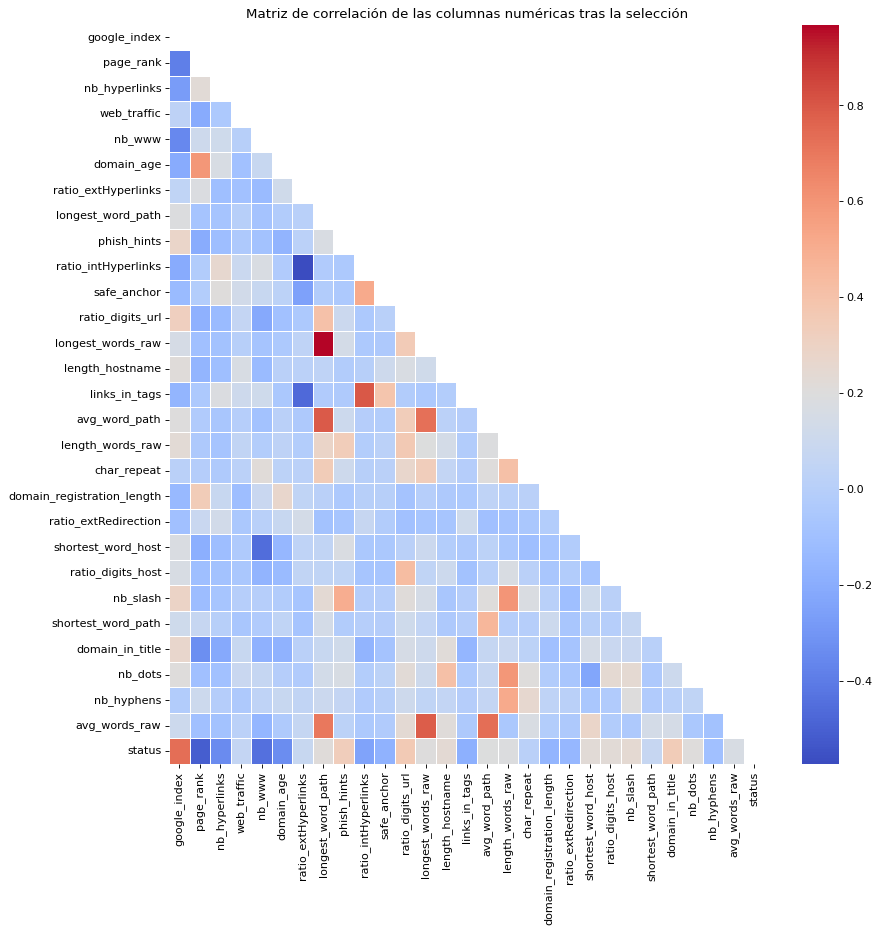

In [36]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=80)

corr = data[columnas_importantes].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', linewidths=.5, annot=False, ax=ax)
ax.set_title('Matriz de correlación de las columnas numéricas tras la selección')

plt.show()

Ahora hacemos que el dataframe original se quede solo con las columnas importantes, las que tienen un feature importance por encima de 0,01. Con este dataframe trabajaremos.

In [10]:
data_real = list(set(data.columns).intersection(set(columnas_importantes)))
data = data[data_real]
data = data.reindex(columns=columnas_importantes)
data

,google_index,page_rank,nb_hyperlinks,web_traffic,nb_www,domain_age,ratio_extHyperlinks,longest_word_path,phish_hints,ratio_intHyperlinks,...,ratio_extRedirection,shortest_word_host,ratio_digits_host,nb_slash,shortest_word_path,domain_in_title,nb_dots,nb_hyphens,avg_words_raw,status
0,1,4,17,0,1,-1,0.470588,6,0,0.529412,...,0.875000,3,0.000000,3,3,0,3,0,5.750000,0
1,1,2,30,0,0,5767,0.033333,32,0,0.966667,...,0.000000,19,0.000000,5,2,1,1,0,15.750000,1
2,1,0,4,5828815,0,4004,0.000000,17,0,1.000000,...,0.000000,3,0.000000,5,2,1,4,1,8.250000,1
3,0,3,149,107721,0,-1,0.026846,0,0,0.973154,...,0.250000,5,0.000000,2,0,1,2,0,5.000000,0
4,0,6,102,8725,1,8175,0.529412,11,0,0.470588,...,0.537037,3,0.000000,5,4,0,2,2,6.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,0,6,199,3980,1,5396,0.115578,11,0,0.884422,...,0.043478,3,0.000000,4,8,0,2,0,7.750000,0
11426,1,0,3,0,1,6728,0.000000,8,0,1.000000,...,0.000000,3,0.000000,5,3,1,5,0,5.166667,1
11427,1,10,68,8,1,8515,0.529412,15,0,0.470588,...,0.000000,3,0.000000,5,1,0,2,6,6.153846,0
11428,0,4,32,2455493,1,2836,0.625000,0,0,0.375000,...,0.050000,3,0.000000,3,0,1,2,0,12.500000,0


Estandarizamos:

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Ahora ya podemos empezar con la comparativa de modelos.

Separamos los datos en X e y del data nuevo ya realizado el feature importance. Utilizaremos como X todas las columnas excepto la columna 'status', que será nuestro vector y.

In [12]:
X = data.iloc[:, 1:-1]
y = data['status']

Bien, pues una vez dividido el dataframe en X e y, vamos a crear los conjuntos de entrenamiento, X_train e y_train; y los conjuntos de prueba, X_test e y_test, para poder empezar a hacer la comparativa de modelos mediante Cross Validation. Utilizaremos un 20% de los datos para los conjuntos de prueba.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Estandarizamos los datos.

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Para poder hacer una comparativa de modelos, debemos revisar primero cuales son los parámetros óptimos en cada modelo para estos datos, para así poder comparar posteriormente los modelos de forma optimizada, con los mejores hiperparámetros de cada uno.

Tenemos diferentes métricas de evaluación que podemos utilizar: accuraccy, recall, f1-score, area bajo la curva ROC. En nuestro caso, debemos tener en cuenta que NO queremos que se nos escape ninguna url que sea phishing, aunque coja como phishing una url legitima. Pero lo que nos interesa es que ningúna url falsa se nos escape. Para eso, nuestra métrica utilizada será el **recall**.

Para ésto, crearemos pipelines de cada uno y haremos GridSearchCV para ver cuales son los mejores hiperparámetros de cada uno, usando como scoring el 'recall'.

Creamos un pipeline para la regresión logistica, marcando un máximo de iteraciones de 10000 para evitar el ConvergeWarning y marcando una semilla.
Definimos la grilla de hiperparámetros que queremos comparar y realizamos el GridsearchCV con 5 validaciones cruzadas y con el Recall Score.
Metemos en variables los mejores parámetros con su recall correspondiente y lo sacamos por pantalla.

In [17]:
pipeline_lr = Pipeline([
        ('classifier', LogisticRegression(max_iter=10000, random_state=42))
    ])

param_grid_lr = {
    'classifier__penalty': ['l2'],
    'classifier__C': [0.1, 1, 10]
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid=param_grid_lr, cv=5, scoring='recall')
grid_search_lr.fit(X_train, y_train)

best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

print(best_params_lr)
print(best_score_lr)

{'classifier__C': 10, 'classifier__penalty': 'l2'}
0.9064532683302329


Creamos un pipeline para realizar un KNN clasificador.
Definimos la grilla de hiperparámetros que queremos comparar y realizamos el GridsearchCV con 5 validaciones cruzadas y con el Recall Score.
Metemos en variables los mejores parámetros con su recall correspondiente y lo sacamos por pantalla.

In [18]:
pipeline_knn = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

param_grid_knn = {
    'classifier__n_neighbors': [3],
    'classifier__weights': ['uniform'],
    'classifier__p': [1]
}

grid_search_knn = GridSearchCV(pipeline_knn, param_grid=param_grid_knn, cv=5, scoring='recall')
grid_search_knn.fit(X_train, y_train)

best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

print(best_params_knn)
print(best_score_knn)

{'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'uniform'}
0.9491913813871605


Creamos un pipeline para un árbol de decisión clasificador, marcando una semilla.
Definimos la grilla de hiperparámetros que queremos comparar y realizamos el GridsearchCV con 5 validaciones cruzadas y con el Recall Score.
Metemos en variables los mejores parámetros con su recall correspondiente y lo sacamos por pantalla.

In [20]:
pipeline_dtc = Pipeline([
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

param_grid_dtc = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

grid_search_dtc = GridSearchCV(pipeline_dtc, param_grid=param_grid_dtc, cv=5, scoring='recall')
grid_search_dtc.fit(X_train, y_train)

best_params_dtc = grid_search_dtc.best_params_
best_score_dtc = grid_search_dtc.best_score_

print(best_params_dtc)
print(best_score_dtc)

{'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
0.9223733259206991


Creamos un pipeline para una maquina de vector soporte clasificatoria, marcando una semilla.
Definimos la grilla de hiperparámetros que queremos comparar y realizamos el GridsearchCV con 5 validaciones cruzadas y con el Recall Score.
Metemos en variables los mejores parámetros con su recall correspondiente y lo sacamos por pantalla.

In [21]:
pipeline_svc = Pipeline([
        ('classifier', SVC(random_state=42))
    ])

param_grid_svc = {
    'classifier__kernel': ['rbf'],
    'classifier__C': [1],
    'classifier__gamma': ['scale']
}

grid_search_svc = GridSearchCV(pipeline_svc, param_grid=param_grid_svc, cv=5, scoring='recall')
grid_search_svc.fit(X_train, y_train)

best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_

print(best_params_svc)
print(best_score_svc)

{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
0.8857399448328949


Creamos un pipeline para un ensamblado Bagging de regresiones logistica, marcando un máximo de iteraciones de 10000 para evitar el ConvergeWarning y marcando una semilla.
Definimos la grilla de hiperparámetros que queremos comparar tanto del Baggging como los del modelo que vamos a ensamblar y realizamos el GridsearchCV con 5 validaciones cruzadas y con el Recall Score.
Metemos en variables los mejores parámetros con su recall correspondiente y lo sacamos por pantalla.

In [22]:
pipe_bag_lr = Pipeline([
    ('classifier', BaggingClassifier(LogisticRegression(max_iter=10000, random_state=42)))
])

param_grid_bag_lr = {
    'classifier__n_estimators': [10],
    'classifier__max_samples': [0.5, 0.7, 0.9],
    'classifier__max_features': [0.5, 0.7, 0.9],
    'classifier__base_estimator__penalty': ['l2'],
    'classifier__base_estimator__C': [0.1]
}

grid_search_bag_lr = GridSearchCV(pipe_bag_lr, param_grid=param_grid_bag_lr, cv=5, scoring='recall')
grid_search_bag_lr.fit(X_train, y_train)

best_params_bag_lr = grid_search_bag_lr.best_params_
best_score_bag_lr = grid_search_bag_lr.best_score_

print(best_params_bag_lr)
print(best_score_bag_lr)

{'classifier__base_estimator__C': 0.1, 'classifier__base_estimator__penalty': 'l2', 'classifier__max_features': 0.5, 'classifier__max_samples': 0.9, 'classifier__n_estimators': 10}
0.8118138858596874


Creamos un pipeline para un ensamblado Bagging de KNN's clasificadores.
Definimos la grilla de hiperparámetros que queremos comparar tanto del Baggging como los del modelo que vamos a ensamblar y realizamos el GridsearchCV con 5 validaciones cruzadas y con el Recall Score.
Metemos en variables los mejores parámetros con su recall correspondiente y lo sacamos por pantalla.

In [23]:
pipe_bag_knn = Pipeline([
    ('classifier', BaggingClassifier(KNeighborsClassifier()))
])

param_grid_bag_knn = {
    'classifier__n_estimators': [10],
    'classifier__max_samples': [0.5, 0.7, 0.9],
    'classifier__max_features': [0.5, 0.7, 0.9],
    'classifier__base_estimator__n_neighbors': [7],
    'classifier__base_estimator__weights': ['distance'],
    'classifier__base_estimator__p': [1]
}

grid_search_bag_knn = GridSearchCV(pipe_bag_knn, param_grid=param_grid_bag_knn, cv=5, scoring='recall')
grid_search_bag_knn.fit(X_train, y_train)

best_params_bag_knn = grid_search_bag_knn.best_params_
best_score_bag_knn = grid_search_bag_knn.best_score_

print(best_params_bag_knn)
print(best_score_bag_knn)

{'classifier__base_estimator__n_neighbors': 7, 'classifier__base_estimator__p': 1, 'classifier__base_estimator__weights': 'distance', 'classifier__max_features': 0.5, 'classifier__max_samples': 0.5, 'classifier__n_estimators': 10}
0.9018728780740457


Creamos un pipeline para un ensamblado Bagging de máquinas de vector soporte clasificadoras, marcando una semilla.
Definimos la grilla de hiperparámetros que queremos comparar tanto del Baggging como los del modelo que vamos a ensamblar y realizamos el GridsearchCV con 5 validaciones cruzadas y con el Recall Score.
Metemos en variables los mejores parámetros con su recall correspondiente y lo sacamos por pantalla.

In [24]:
pipe_bag_svc = Pipeline([
    ('classifier', BaggingClassifier(SVC(random_state=42)))
])

param_grid_bag_svc = {
    'classifier__n_estimators': [10],
    'classifier__max_samples': [0.5, 0.7, 0.9],
    'classifier__max_features': [0.5, 0.7, 0.9],
    'classifier__base_estimator__C':[1],
    'classifier__base_estimator__kernel': ['rbf'],
    'classifier__base_estimator__gamma': ['scale']
}

grid_search_bag_svc = GridSearchCV(pipe_bag_svc, param_grid=param_grid_bag_svc, cv=5, scoring='recall')
grid_search_bag_svc.fit(X_train, y_train)

best_params_bag_svc = grid_search_bag_svc.best_params_
best_score_bag_svc = grid_search_bag_svc.best_score_

print(best_params_bag_svc)
print(best_score_bag_svc)

{'classifier__base_estimator__C': 1, 'classifier__base_estimator__gamma': 'scale', 'classifier__base_estimator__kernel': 'rbf', 'classifier__max_features': 0.9, 'classifier__max_samples': 0.5, 'classifier__n_estimators': 10}
0.8872668999745785


Creamos un pipeline para un Random Forest, marcando una semilla.
Definimos la grilla de hiperparámetros que queremos comparar y realizamos el GridsearchCV con 5 validaciones cruzadas y con el Recall Score.
Metemos en variables los mejores parámetros con su recall correspondiente y lo sacamos por pantalla.

In [25]:
pipe_rfc = Pipeline([
        ('classifier', RandomForestClassifier(random_state=42))
    ])

param_grid_rfc = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

grid_search_rfc = GridSearchCV(pipe_rfc, param_grid=param_grid_rfc, cv=5, scoring='recall')
grid_search_rfc.fit(X_train, y_train)

best_params_rfc = grid_search_rfc.best_params_
best_score_rfc = grid_search_rfc.best_score_

print(best_params_rfc)
print(best_score_rfc)

{'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
0.9611846434926813


Creamos un pipeline para un ensamblado AdaBoost clasificador ensamblando arboles de decisión, marcando una semilla.
Definimos la grilla de hiperparámetros que queremos comparar tanto del Boosting como los del modelo que vamos a ensamblar y realizamos el GridsearchCV con 5 validaciones cruzadas y con el Recall Score.
Metemos en variables los mejores parámetros con su recall correspondiente y lo sacamos por pantalla.

In [27]:
pipe_abc = Pipeline([
        ('classifier', AdaBoostClassifier(DecisionTreeClassifier(random_state=42)))
    ])

param_grid_abc = {
    'classifier__n_estimators': [200],
    'classifier__learning_rate': [0.1, 0.5, 1],
    'classifier__base_estimator__max_depth': [None, 5, 10],
    'classifier__base_estimator__min_samples_split': [2],
    'classifier__base_estimator__min_samples_leaf': [1]
}

grid_search_abc = GridSearchCV(pipe_abc, param_grid=param_grid_abc, cv=5, scoring='recall')
grid_search_abc.fit(X_train, y_train)

best_params_abc = grid_search_abc.best_params_
best_score_abc = grid_search_abc.best_score_

print(best_params_abc)
print(best_score_abc)

{'classifier__base_estimator__max_depth': 5, 'classifier__base_estimator__min_samples_leaf': 1, 'classifier__base_estimator__min_samples_split': 2, 'classifier__learning_rate': 1, 'classifier__n_estimators': 200}
0.9507195244510018


Creamos un pipeline para un GradientBoosting de clasificación.
Definimos la grilla de hiperparámetros que queremos comparar y realizamos el GridsearchCV con 5 validaciones cruzadas y con el Recall Score.
Metemos en variables los mejores parámetros con su recall correspondiente y lo sacamos por pantalla.

In [28]:
pipe_gbc = Pipeline([
        ('classifier', GradientBoostingClassifier())
    ])

param_grid_gbc = {
    'classifier__n_estimators': [200],
    'classifier__learning_rate': [0.1, 0.5, 1],
    'classifier__max_depth': [None],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [1],
    'classifier__max_features': ['log2']
}

grid_search_gbc = GridSearchCV(pipe_gbc, param_grid=param_grid_gbc, cv=5, scoring='recall')
grid_search_gbc.fit(X_train, y_train)

best_params_gbc = grid_search_gbc.best_params_
best_score_gbc = grid_search_gbc.best_score_

print(best_params_gbc)
print(best_score_gbc)

{'classifier__learning_rate': 0.1, 'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
0.962929463558112


Creamos un pipeline para un extreme gradient boosting clasificador.
Definimos la grilla de hiperparámetros que queremos comparar y realizamos el GridsearchCV con 5 validaciones cruzadas y con el Recall Score.
Metemos en variables los mejores parámetros con su recall correspondiente y lo sacamos por pantalla.

In [32]:
pipe_xgb = Pipeline([
        ('classifier', XGBClassifier())
    ])

param_grid_xgb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.1, 0.5, 1],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_child_weight': [1, 2, 4],
    'classifier__subsample': [0.5, 0.7, 0.9],
    'classifier__colsample_bytree': [0.5, 0.7, 0.9],
    'classifier__reg_alpha': [0, 0.1, 1],
    'classifier__reg_lambda': [0, 0.1, 1]
}

grid_search_xgb = GridSearchCV(pipe_xgb, param_grid=param_grid_xgb, cv=5, scoring='recall')
grid_search_xgb.fit(X_train, y_train)

best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

print(best_params_xgb)
print(best_score_xgb)

{'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': None, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 200, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 0.1, 'classifier__subsample': 0.9}
0.9653276408103529


Vamos a hacer una lista a la que llamaremos 'modelos' donde meteremos todos los modelos que vamos a comparar, para posteriormente, crear un dataframe de comparación de modelos. Primeramente vamos a declarar variables a los distintos tipos de BaggingClassifier para poder diferenciarlos.

In [34]:
BaggingClassifier_LR = BaggingClassifier(base_estimator=LogisticRegression(max_iter=10000, penalty='l2', C=0.1, random_state=42), max_features=0.5, 
                                         max_samples=0.7, n_estimators=10)
BaggingClassifier_KNN = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=7, p=1, weights='distance'), 
                                          max_features=0.5, max_samples=0.7, n_estimators=10)
BaggingClassifier_SVC = BaggingClassifier(base_estimator=SVC(C=1, gamma='scale', kernel='rbf', random_state=42), max_features=0.5, max_samples=0.5, n_estimators=10)

In [35]:
modelos = [LogisticRegression(max_iter=10000, penalty='l2', C=1, random_state=42), KNeighborsClassifier(n_neighbors=7, p=0.1, weights='distance'), 
           DecisionTreeClassifier(criterion='entropy', max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2, random_state=42), 
           SVC(C=1, gamma='scale', kernel='rbf', random_state=42), BaggingClassifier_LR, BaggingClassifier_KNN, BaggingClassifier_SVC, 
           RandomForestClassifier(max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42), 
           AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, random_state=42), learning_rate=0.1, n_estimators=200),
           GradientBoostingClassifier(learning_rate=0.5, max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=200), 
           XGBClassifier(colsample_bytree=0.5, learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9)]

In [36]:
modelos_optimos = [{'Modelo': modelos[0], 'Parámetros óptimos': best_params_lr, 'Score (Recall)': best_score_lr},
           {'Modelo': modelos[1], 'Parámetros óptimos': best_params_knn, 'Score (Recall)': best_score_knn},
           {'Modelo': modelos[2], 'Parámetros óptimos': best_params_dtc, 'Score (Recall)': best_score_dtc},
           {'Modelo': modelos[3], 'Parámetros óptimos': best_params_svc, 'Score (Recall)': best_score_svc},
           {'Modelo': modelos[4], 'Parámetros óptimos': best_params_bag_lr, 'Score (Recall)': best_score_bag_lr},
           {'Modelo': modelos[5], 'Parámetros óptimos': best_params_bag_knn, 'Score (Recall)': best_score_bag_knn},
           {'Modelo': modelos[6], 'Parámetros óptimos': best_params_bag_svc, 'Score (Recall)': best_score_bag_svc},
           {'Modelo': modelos[7], 'Parámetros óptimos': best_params_rfc, 'Score (Recall)': best_score_rfc},
           {'Modelo': modelos[8], 'Parámetros óptimos': best_params_abc, 'Score (Recall)': best_score_abc},
           {'Modelo': modelos[9], 'Parámetros óptimos': best_params_gbc, 'Score (Recall)': best_score_gbc},
           {'Modelo': modelos[10], 'Parámetros óptimos': best_params_xgb, 'Score (Recall)': best_score_xgb}]

model_comparison = pd.DataFrame(modelos_optimos)
model_comparison

,Modelo,Parámetros óptimos,Score (Recall)
0,"LogisticRegression(C=1, max_iter=10000, random...","{'classifier__C': 0.1, 'classifier__penalty': ...",0.708450
1,"KNeighborsClassifier(n_neighbors=7, p=0.1, wei...","{'classifier__n_neighbors': 7, 'classifier__p'...",0.886614
2,"DecisionTreeClassifier(criterion='entropy', ma...","{'classifier__criterion': 'entropy', 'classifi...",0.922373
3,"SVC(C=1, random_state=42)","{'classifier__C': 1, 'classifier__gamma': 'sca...",0.885740
4,BaggingClassifier(base_estimator=LogisticRegre...,"{'classifier__base_estimator__C': 0.1, 'classi...",0.811814
5,BaggingClassifier(base_estimator=KNeighborsCla...,"{'classifier__base_estimator__n_neighbors': 7,...",0.901873
6,"BaggingClassifier(base_estimator=SVC(C=1, rand...","{'classifier__base_estimator__C': 1, 'classifi...",0.887267
7,"RandomForestClassifier(max_features='log2', n_...","{'classifier__max_depth': 20, 'classifier__max...",0.961185
8,AdaBoostClassifier(base_estimator=DecisionTree...,"{'classifier__base_estimator__max_depth': 5, '...",0.950720
9,"GradientBoostingClassifier(learning_rate=0.5, ...","{'classifier__learning_rate': 0.1, 'classifier...",0.962929


In [37]:
model_comparison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Modelo              11 non-null     object 
 1   Parámetros óptimos  11 non-null     object 
 2   Score (Recall)      11 non-null     float64
dtypes: float64(1), object(2)
memory usage: 392.0+ bytes


Ahora vamos a ajustar el modelo elegido (XGBClassifier()) en el conjunto de entrenamiento, X_train e y_train, y vamos a hallar la predicción para poder tener el score del conjunto de prueba:

In [44]:
modelo_elegido = XGBClassifier(colsample_bytree=0.5, learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9)
modelo_elegido.fit(X_train, y_train)
y_pred = modelo_elegido.predict(X_test)

Aplicamos el modelo que tiene más rendimiento, el XGBClassiffier() y lo entrenamos con el conjunto de entrenamiento para posteriormente predecir con X_test. Posteriormente, calcularemos la score del recall.

In [45]:
test_score = recall_score(y_test, y_pred)
test_score

0.9574844995571302

Por tanto, podemos concluir que:

- La métrica que mejor se adapta a los datos es el recall por la naturaleza de los datos y el resultado que queremos obtener.
- El modelo que mejor rendimiento ha obtenido es el modelo XGBClassifier(), con un rendimiento de 96.53%.
- El score del recall del modelo en el conjunto de prueba es de 95.74%.

In [53]:
#model_comparison.to_csv('../data/processed/model_comparison.csv')
#data.to_csv('../data/processed/dataset_modelo.csv', index=False)